# Курсовой проект Библиотеки Python для Data Science: продолжение<a class="anchor" id="task"></a>

### Постановка задачи<a class="anchor" id="task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

# Вариант решения: EDA<a class="anchor" id="task"></a>

**План работы, заметки**

В варианте масштабирования делаем более подробный и тщательный EDA, обрабатываем пропуски с помощью моделей предсказания.

1. Минимально познакомиться с данными
2. Заполнить пропуски простым методом (медиана, мода)
3. Отмасшабировать данные
4. Обучить модели
5. Посчитать метрику качества

**Подключение библиотек**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import missingno
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

from pathlib import Path

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, \
                                     RandomizedSearchCV, ShuffleSplit, cross_val_score, \
                                     learning_curve)
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score, r2_score)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

**Скрипты**

In [2]:
#Уменьшение памяти, занимаемой датасетом
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
           # df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def categorical_eda(df):
    """Given dataframe, generate EDA of categorical data"""
    print("To check: Unique count of non-numeric data")
    print(df.select_dtypes(include=['object']).nunique())
    df.head(10)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='object').columns:
        fig = sns.catplot(x=col, kind="count", data=df)
        fig.set_xticklabels(rotation=90)
        plt.show()

In [10]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()
    
    # Plot the pairwise joint distributions
#     print("\nTo check pairwise joint distribution of numeric data")
#     if hue==None:
#         sns.pairplot(df.select_dtypes(include=np.number))
#     else:
#         sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
#     plt.show()

In [11]:
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

**Пути к директориям и файлам**

In [12]:
DATA_PATH = Path('C:/Users/Данила/Documents/Data science/Python библиотеки 2/course_project')

# input
TRAIN_DATASET_PATH = DATA_PATH / 'train.csv'
TEST_DATASET_PATH = DATA_PATH / 'test.csv'

# output
PREP_TRAIN_B_PATH = DATA_PATH / 'train_prep_basic.csv'
PREP_TEST_B_PATH = DATA_PATH / 'test_prep_basic.csv'
SCALER_FILE_PATH = DATA_PATH / 'scaler.pkl'
MODEL_FILE_PATH = DATA_PATH / 'model.pkl'

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [13]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.rename(columns = {'Home Ownership':'Home_Ownership',
                           'Annual Income':'Annual_Income',
                           'Years in current job':'Years_in_current_job',
                           'Tax Liens':'Tax_Liens',
                           'Number of Open Accounts':'Number_of_Open_Accounts',
                           'Years of Credit History':'Years_of_Credit_History',
                           'Maximum Open Credit':'Maximum_Open_Credit',
                           'Number of Credit Problems':'Number_of_Credit_Problems',
                           'Months since last delinquent':'Months_since_last_delinquent',
                           'Current Loan Amount':'Current_Loan_Amount',
                           'Current Credit Balance':'Current_Credit_Balance',
                           'Monthly Debt':'Monthly_Debt',
                           'Credit Score':'Credit_Score',
                           'Credit Default':'Credit_Default'}, inplace = True)
train_df.head()

Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [14]:
train_df.shape

(7500, 17)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                7500 non-null   object 
 1   Annual_Income                 5943 non-null   float64
 2   Years_in_current_job          7129 non-null   object 
 3   Tax_Liens                     7500 non-null   float64
 4   Number_of_Open_Accounts       7500 non-null   float64
 5   Years_of_Credit_History       7500 non-null   float64
 6   Maximum_Open_Credit           7500 non-null   float64
 7   Number_of_Credit_Problems     7500 non-null   float64
 8   Months_since_last_delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current_Loan_Amount           7500 non-null   float64
 13  Cur

In [16]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.rename(columns = {'Home Ownership':'Home_Ownership',
                          'Annual Income':'Annual_Income',
                          'Years in current job':'Years_in_current_job',
                          'Tax Liens':'Tax_Liens',
                          'Number of Open Accounts':'Number_of_Open_Accounts',
                          'Years of Credit History':'Years_of_Credit_History',
                          'Maximum Open Credit':'Maximum_Open_Credit',
                          'Number of Credit Problems':'Number_of_Credit_Problems',
                          'Months since last delinquent':'Months_since_last_delinquent',
                          'Current Loan Amount':'Current_Loan_Amount',
                          'Current Credit Balance':'Current_Credit_Balance',
                          'Monthly Debt':'Monthly_Debt',
                          'Credit Score':'Credit_Score',
                          'Credit Default':'Credit_Default'}, inplace = True)
test_df.head()

Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current_Loan_Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [17]:
test_df.shape

(2500, 16)

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                2500 non-null   object 
 1   Annual_Income                 1987 non-null   float64
 2   Years_in_current_job          2414 non-null   object 
 3   Tax_Liens                     2500 non-null   float64
 4   Number_of_Open_Accounts       2500 non-null   float64
 5   Years_of_Credit_History       2500 non-null   float64
 6   Maximum_Open_Credit           2500 non-null   float64
 7   Number_of_Credit_Problems     2500 non-null   float64
 8   Months_since_last_delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current_Loan_Amount           2500 non-null   float64
 13  Cur

**Приведение типов**

In [19]:
for colname in ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']:
    train_df[colname] = train_df[colname].astype(str)
for colname in ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']:
    test_df[colname] = test_df[colname].astype(str)

**Уменьшение объема памяти датасета**

In [20]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2.68 MB
Memory usage after optimization is: 2.28 MB
Decreased by 14.7%


In [21]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.87 MB
Memory usage after optimization is: 0.76 MB
Decreased by 13.1%


**Проверка наличия дублированных записей**

In [22]:
if len(train_df[train_df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(train_df[train_df.duplicated()]))
    print(train_df[train_df.duplicated(keep=False)].sort_values(by=list(train_df.columns)).head())
    train_df.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No duplicated entries found


In [23]:
if len(test_df[test_df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(test_df[test_df.duplicated()]))
    print(test_df[test_df.duplicated(keep=False)].sort_values(by=list(test_df.columns)).head())
    test_df.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No duplicated entries found


**Выделение целевой переменной и групп признаков**

In [24]:
TARGET_NAME = 'Credit_Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = ['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
                     'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent', 'Bankruptcies',
                     'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt']

CAT_FEATURE_NAMES = ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

**Обзор целевой переменной**

In [25]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

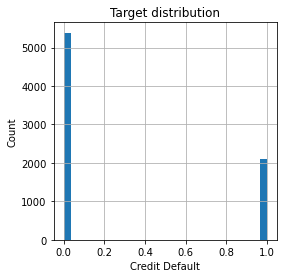

In [26]:
plt.figure(figsize = (4, 4))

train_df[TARGET_NAME].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Credit Default')

plt.title('Target distribution')
plt.show()

**Обзор количественных признаков**

In [27]:
train_df.describe()

Annual_Income    Tax_Liens  Number_of_Open_Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366390e+06     0.030133                11.130934   
std     8.453384e+05     0.271613                 4.908937   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years_of_Credit_History  Maximum_Open_Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317446         9.451526e+05   
std                   7.041938         1.602614e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.799999         7.935015e+05   
max                  57.700001         1.304726e+09   

       Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
count                  7500.0000                   3419.000000   7486.000000   
mean                      0.1700                     34.692600      0.117152   
std                       0.4986                     21.688801      0.347197   
min                       0.0000                      0.000000      0.000000   
25%                       0.0000                     16.000000      0.000000   
50%                       0.0000                     32.000000      0.000000   
75%                       0.0000                     50.000000      0.000000   
max                       7.0000                    118.000000      4.000000   

       Current_Loan_Amount  Current_Credit_Balance   Monthly_Debt  \
count               7500.0            7.500000e+03    7500.000000   
mean            11873135.0            2.898332e+05   18314.453125   
std             31926302.0            3.178713e+05   11926.758789   
min                11242.0            0.000000e+00       0.000000   
25%               180169.0            1.142565e+05   10067.500000   
50%               309573.0            2.093230e+05   16076.500000   
75%               519882.0            3.604062e+05   23818.000000   
max            100000000.0            6.506797e+06  136679.000000   

       Credit_Score  Credit_Default  
count   5943.000000     7500.000000  
mean    1151.087524        0.281733  
std     1604.447510        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

array([[<AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Tax_Liens'}>,
        <AxesSubplot:title={'center':'Number_of_Open_Accounts'}>],
       [<AxesSubplot:title={'center':'Years_of_Credit_History'}>,
        <AxesSubplot:title={'center':'Maximum_Open_Credit'}>,
        <AxesSubplot:title={'center':'Number_of_Credit_Problems'}>],
       [<AxesSubplot:title={'center':'Months_since_last_delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current_Loan_Amount'}>],
       [<AxesSubplot:title={'center':'Current_Credit_Balance'}>,
        <AxesSubplot:title={'center':'Monthly_Debt'}>, <AxesSubplot:>]],
      dtype=object)

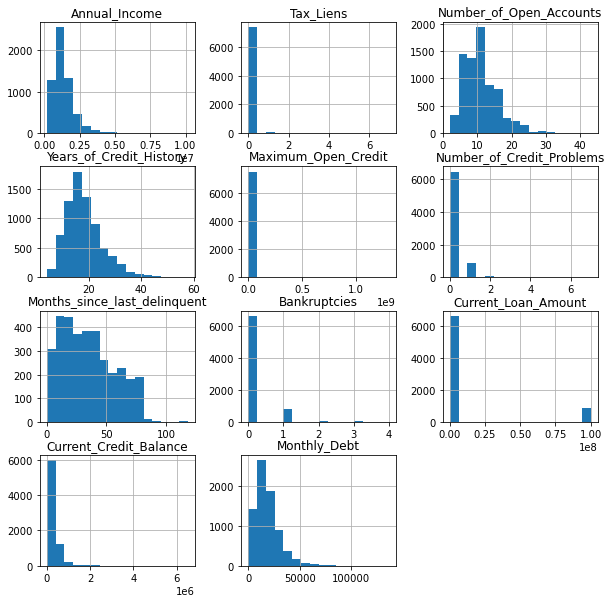

In [28]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(10, 10), bins=16, grid=True)

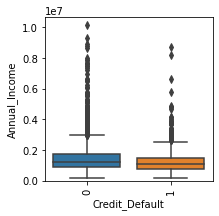

In [29]:
var = 'Annual_Income'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(3, 3))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.05);
plt.xticks(rotation=90);

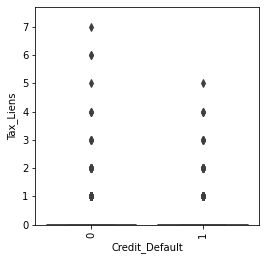

In [30]:
var = 'Tax_Liens'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
plt.xticks(rotation=90);

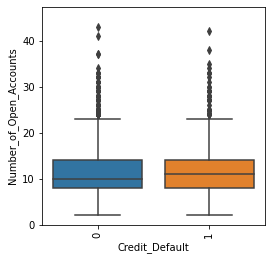

In [31]:
var = 'Number_of_Open_Accounts'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
plt.xticks(rotation=90);

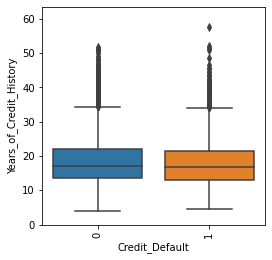

In [32]:
var = 'Years_of_Credit_History'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
plt.xticks(rotation=90);

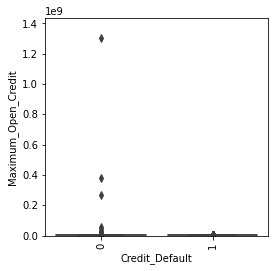

In [33]:
var = 'Maximum_Open_Credit'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
plt.xticks(rotation=90);

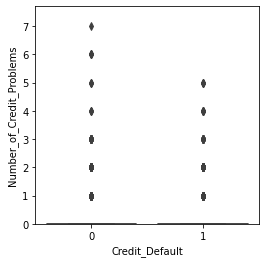

In [34]:
var = 'Number_of_Credit_Problems'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);

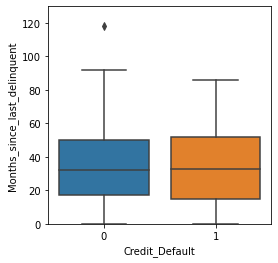

In [35]:
var = 'Months_since_last_delinquent'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);

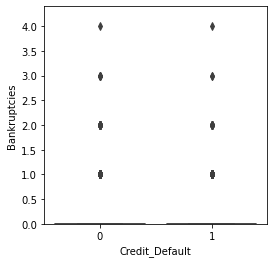

In [36]:
var = 'Bankruptcies'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);

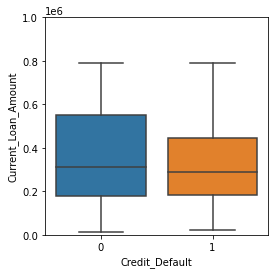

In [37]:
var = 'Current_Loan_Amount'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=1000000);
#plt.xticks(rotation=90);

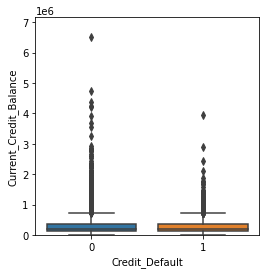

In [38]:
var = 'Current_Credit_Balance'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);

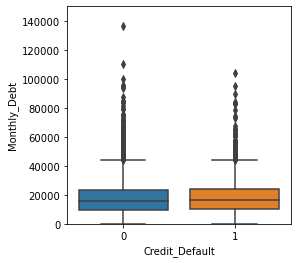

In [39]:
var = 'Monthly_Debt'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Default", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);

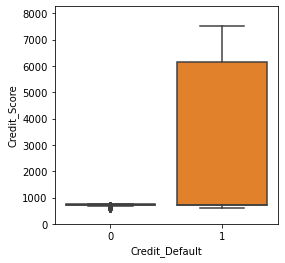

In [40]:
var = 'Credit_Score'
data = pd.concat([train_df[var], train_df['Credit_Default']], axis=1)
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.boxplot(x="Credit_Score", y=var, data=data)
fig.axis(ymin=0, ymax=train_df[var].max()*1.1);
#plt.xticks(rotation=90);


To check: 
Distribution of numeric data


count          mean           std       min  \
Annual_Income                 5943.0  1.366390e+06  8.453384e+05  164597.0   
Tax_Liens                     7500.0  3.013333e-02  2.716130e-01       0.0   
Number_of_Open_Accounts       7500.0  1.113093e+01  4.908937e+00       2.0   
Years_of_Credit_History       7500.0  1.831745e+01  7.041938e+00       4.0   
Maximum_Open_Credit           7500.0  9.451526e+05  1.602614e+07       0.0   
Number_of_Credit_Problems     7500.0  1.700000e-01  4.986004e-01       0.0   
Months_since_last_delinquent  3419.0  3.469260e+01  2.168880e+01       0.0   
Bankruptcies                  7486.0  1.171520e-01  3.471974e-01       0.0   
Current_Loan_Amount           7500.0  1.187314e+07  3.192630e+07   11242.0   
Current_Credit_Balance        7500.0  2.898332e+05  3.178713e+05       0.0   
Monthly_Debt                  7500.0  1.831445e+04  1.192676e+04       0.0   
Credit_Score                  5943.0  1.151088e+03  1.604448e+03     585.0   
Credit_Default                7500.0  2.817333e-01  4.498740e-01       0.0   

                                   25%        50%           75%           max  
Annual_Income                 844341.0  1168386.0  1.640137e+06  1.014934e+07  
Tax_Liens                          0.0        0.0  0.000000e+00  7.000000e+00  
Number_of_Open_Accounts            8.0       10.0  1.400000e+01  4.300000e+01  
Years_of_Credit_History           13.5       17.0  2.180000e+01  5.770000e+01  
Maximum_Open_Credit           279229.5   478159.0  7.935015e+05  1.304726e+09  
Number_of_Credit_Problems          0.0        0.0  0.000000e+00  7.000000e+00  
Months_since_last_delinquent      16.0       32.0  5.000000e+01  1.180000e+02  
Bankruptcies                       0.0        0.0  0.000000e+00  4.000000e+00  
Current_Loan_Amount           180169.0   309573.0  5.198820e+05  1.000000e+08  
Current_Credit_Balance        114256.5   209323.0  3.604062e+05  6.506797e+06  
Monthly_Debt                   10067.5    16076.5  2.381800e+04  1.366790e+05  
Credit_Score                     711.0      731.0  7.430000e+02  7.510000e+03  
Credit_Default                     0.0        0.0  1.000000e+00  1.000000e+00

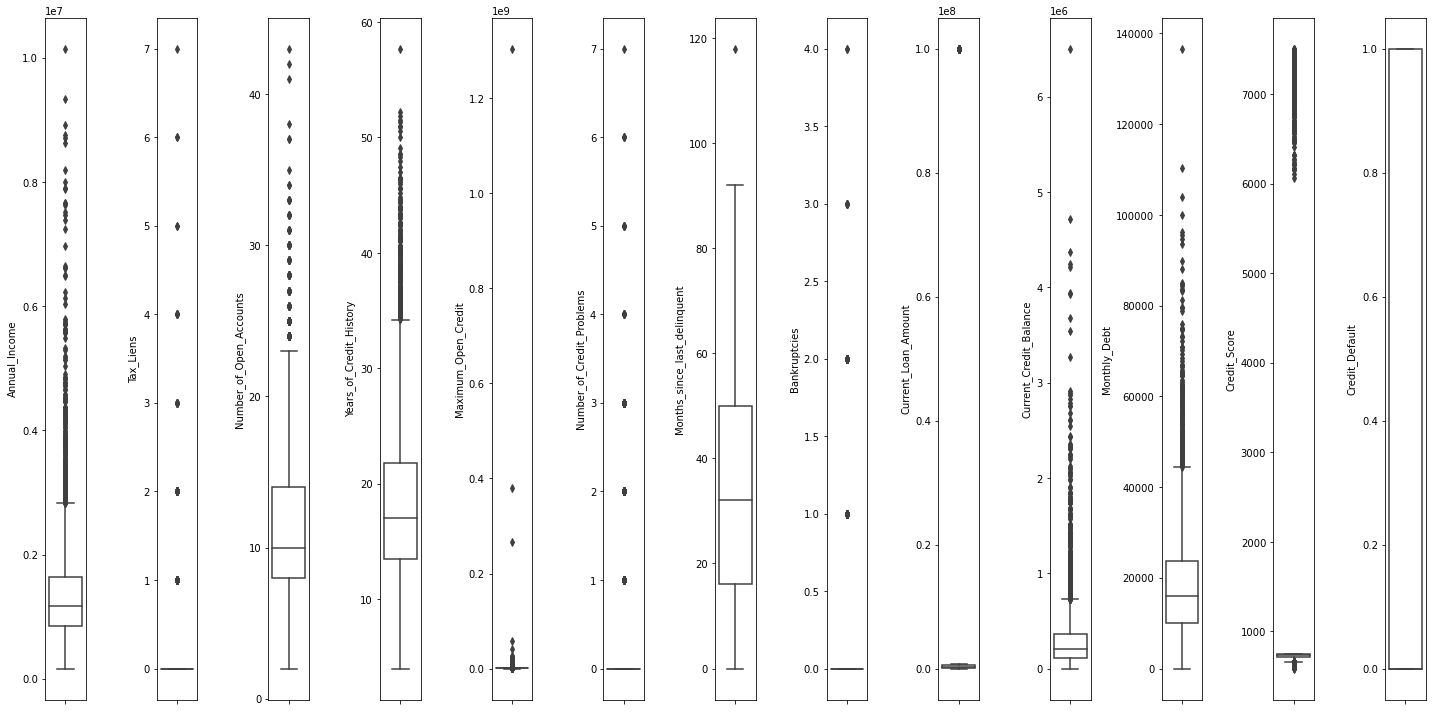

In [41]:
numeric_eda(train_df, hue=None)

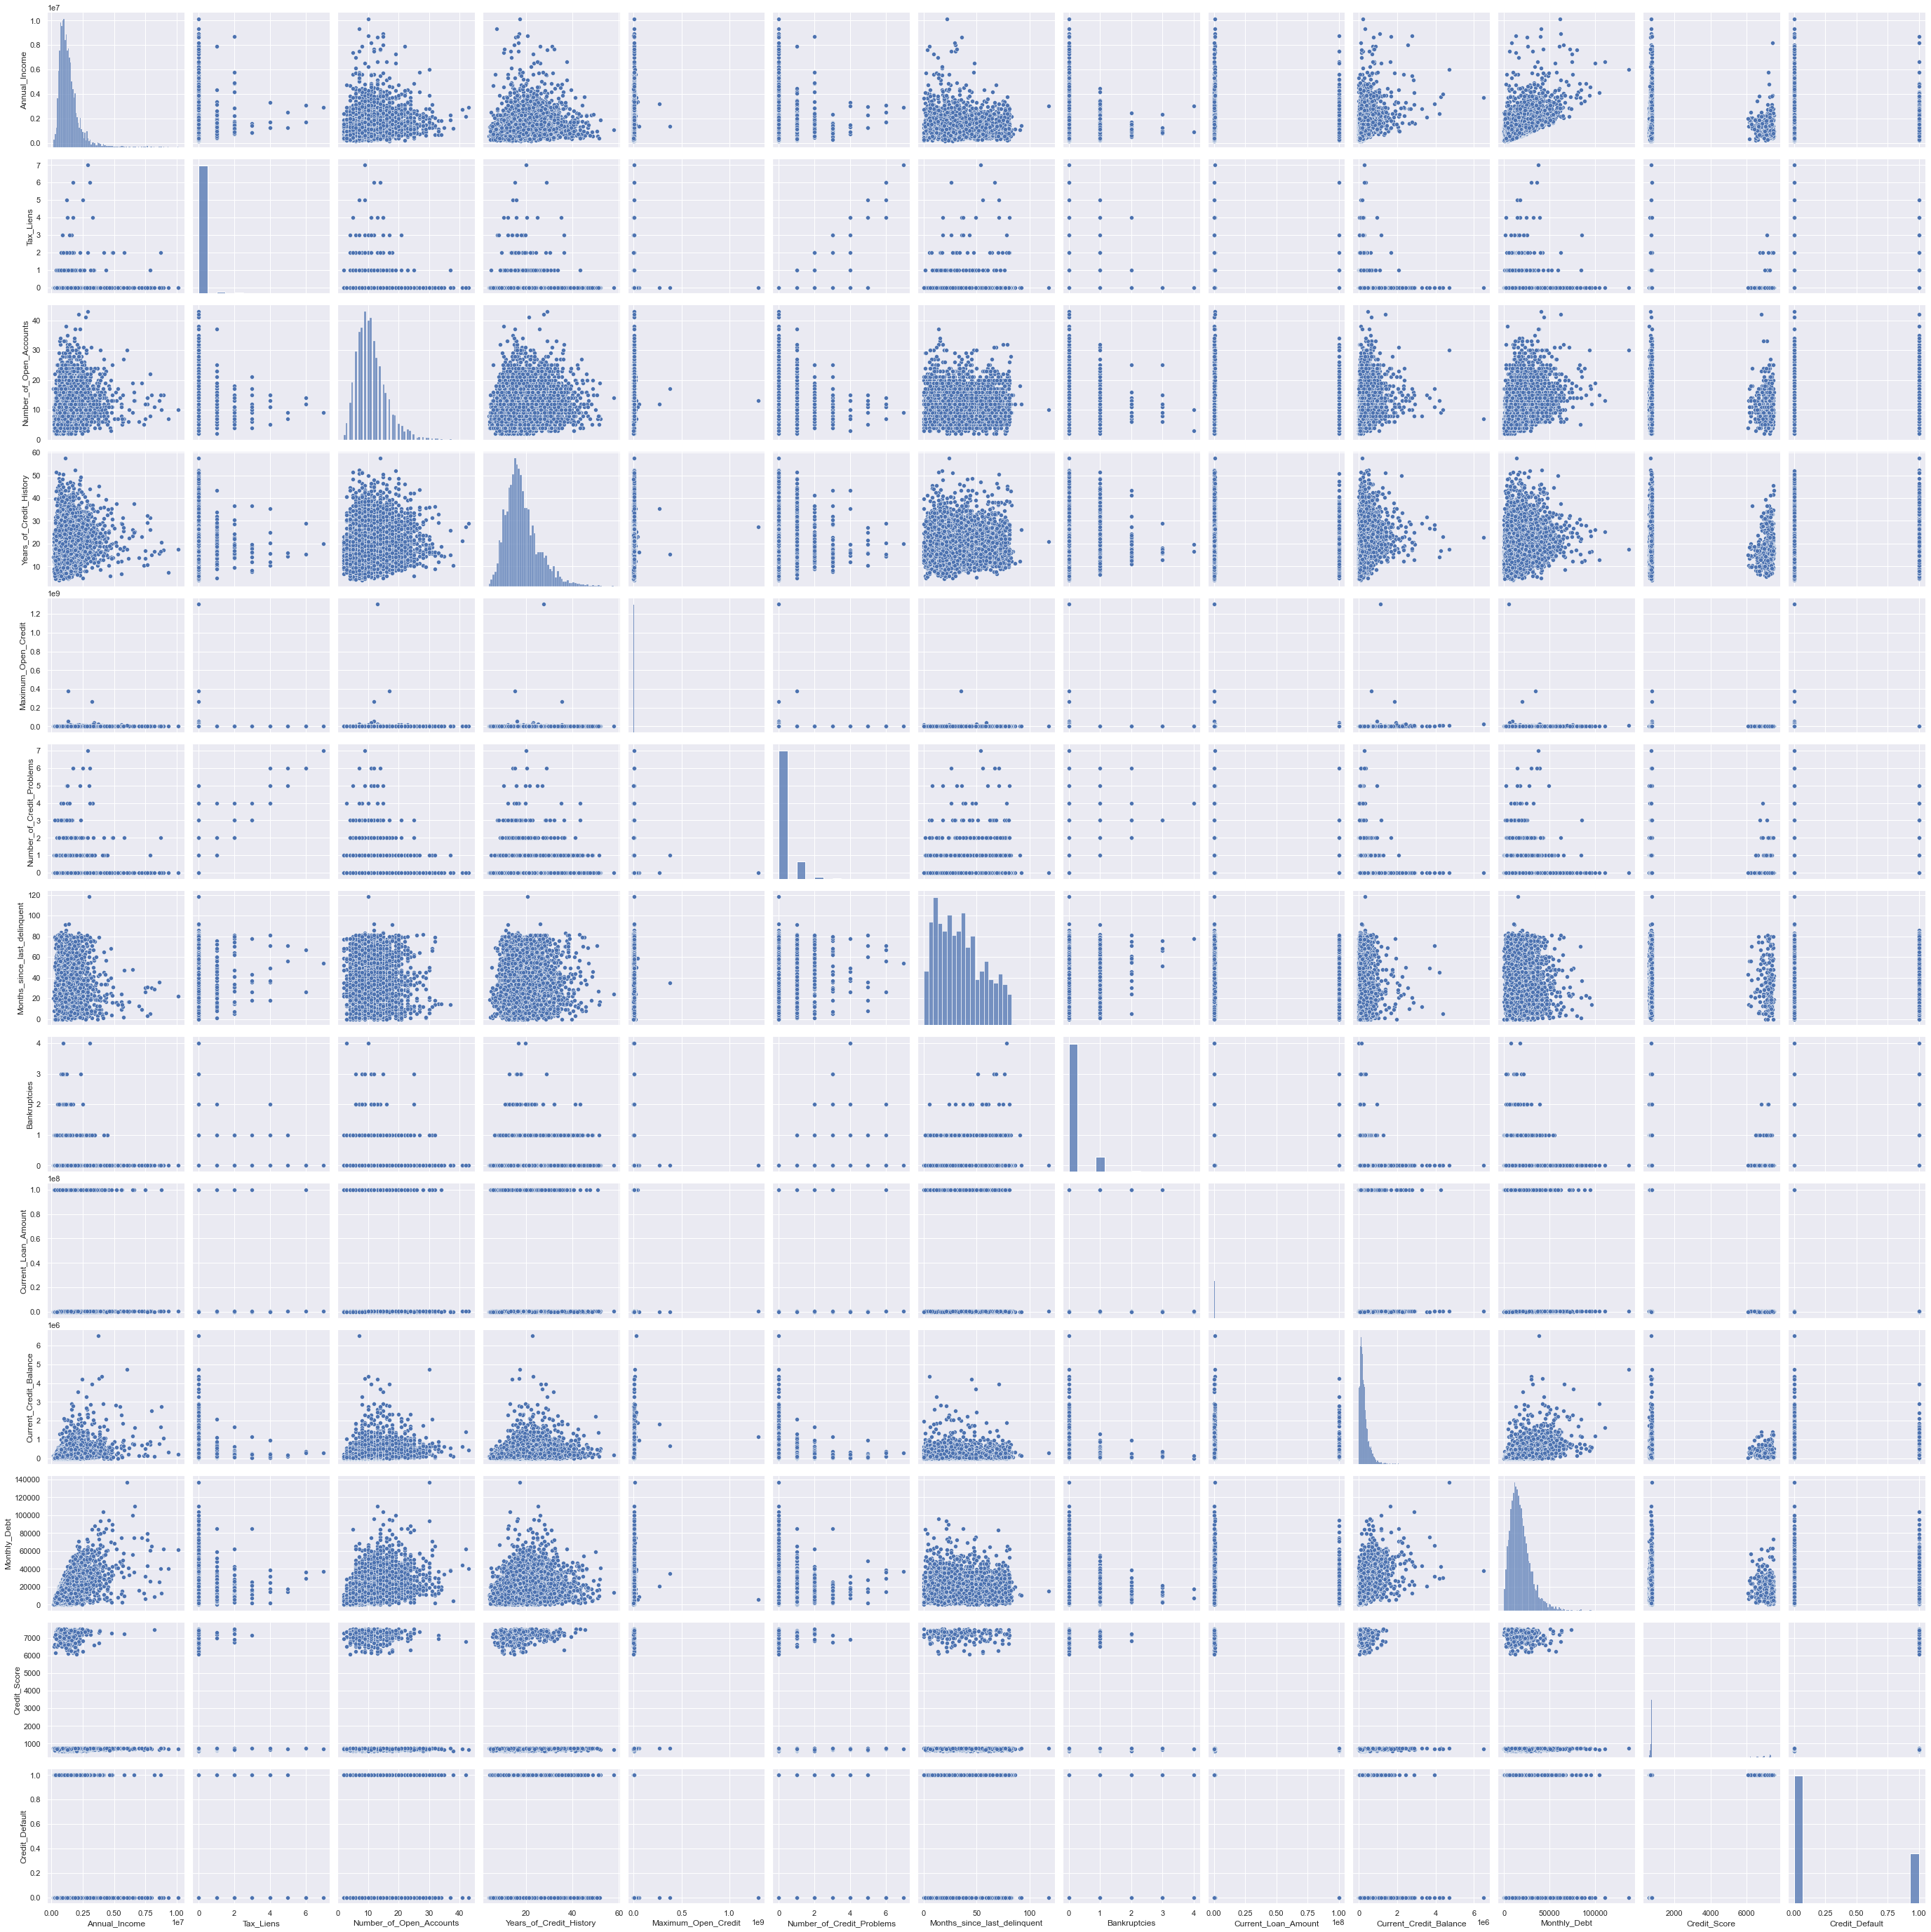

In [42]:
sns.set()
cols = train_df.columns.tolist()
sns.pairplot(train_df[cols], size = 3)
plt.show();

**Оценка корреляций между признаками**

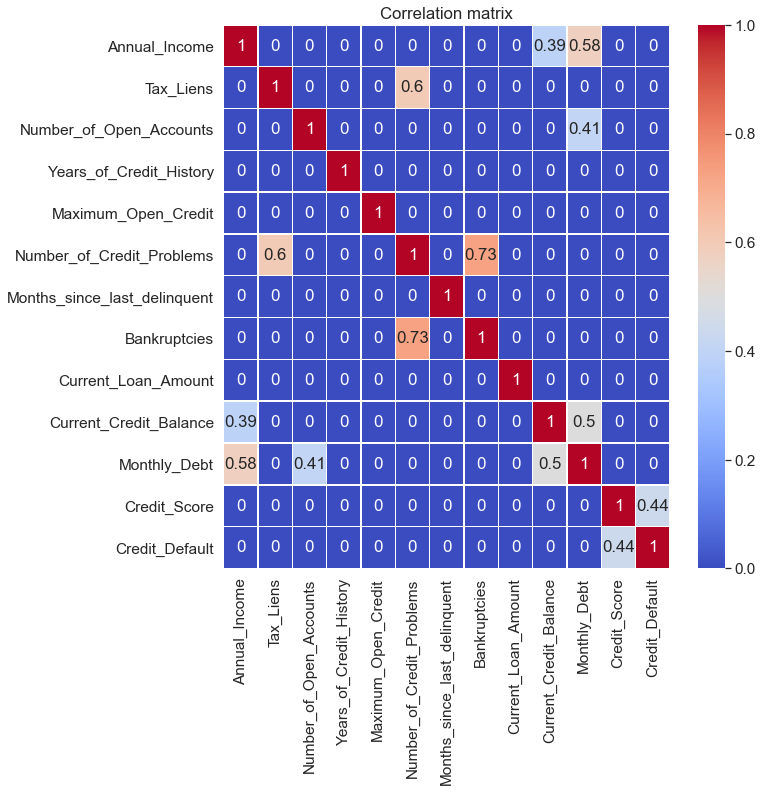

In [43]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Выбросы**

Удаляем все выбросы

In [44]:
train_df.loc[train_df['Annual_Income'] > 5000000, 'Annual_Income'] = np.nan
train_df.loc[train_df['Number_of_Open_Accounts'] > 35, 'Number_of_Open_Accounts'] = np.nan
train_df.loc[train_df['Years_of_Credit_History'] > 55, 'Years_of_Credit_History'] = np.nan
train_df.loc[train_df['Maximum_Open_Credit'] > 200000000, 'Maximum_Open_Credit'] = np.nan
train_df.loc[train_df['Months_since_last_delinquent'] > 100, 'Months_since_last_delinquent'] = np.nan
train_df.loc[train_df['Current_Loan_Amount'] >= 10000000, 'Current_Loan_Amount'] = np.nan
train_df.loc[train_df['Current_Credit_Balance'] >= 3000000, 'Current_Credit_Balance'] = np.nan
train_df.loc[train_df['Monthly_Debt'] >= 77000, 'Monthly_Debt'] = np.nan

***Выводы:***

1. Основные выбросы (там, где есть) лежат сверху.
2. У признаков Annual_Income, Number_of_open_accounts, Year_of_credit_history, Current_credit_balance, Monthly_debt, Credit_Score - очень вытянутые вверх усы - есть смысл сделать новые признаки (меньше верхнего квартиля - 1, больше верхнего квартиля - 0)
3. Совпадают коробки и средние у пар признаков Number_of_open_accounts / Year_of_credit_history, Maximum_Open_Credit / Bankruptcies / Current_Loan_Amount, Tax_Liens / Number_of_Credit_Problems  - проверить, скорее всего один из них можно удалить.
4. В переменной Current_Loan_Amount большой выброс.
5. Наиболее явные различия в распределении значений признака в зависимости от целевой переменной у Credit_Score.
6. Сильная корреляция между Bankruptcies и Number_of_Credit_Problems - возможно, лучше объединить в один признак.

**Обзор номинативных признаков**

In [45]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home_Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64
****************************************************************************************************

Years_in_current_job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

To check: Unique count of non-numeric data
Home_Ownership           4
Years_in_current_job    12
Purpose                 15
Term                     2
dtype: int64


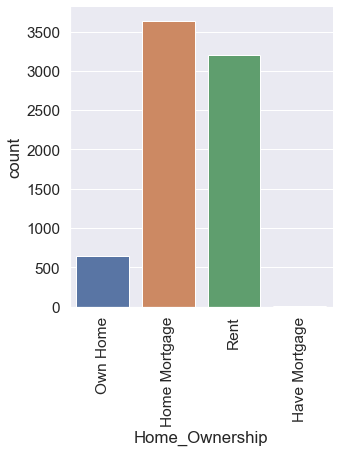

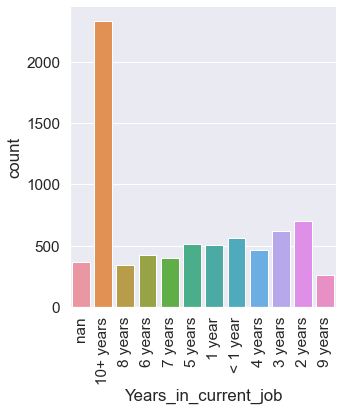

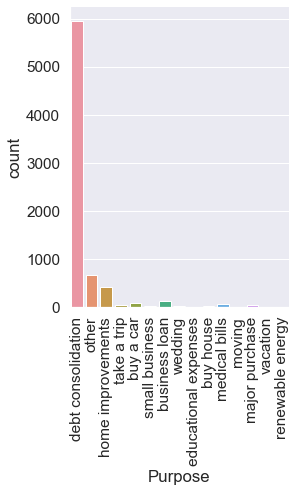

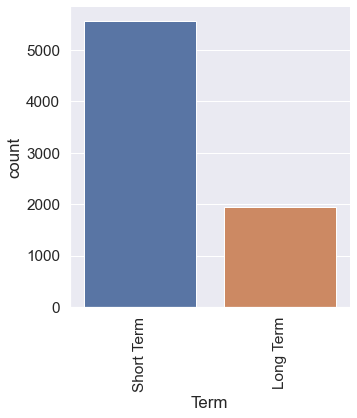

In [46]:
categorical_eda(train_df)

To check: Unique count of non-numeric data
Home_Ownership           4
Years_in_current_job    12
Purpose                 14
Term                     2
dtype: int64


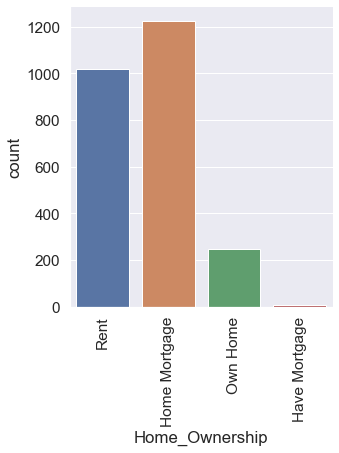

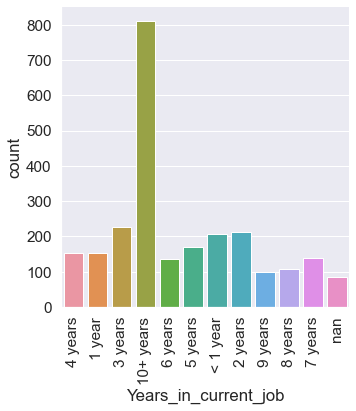

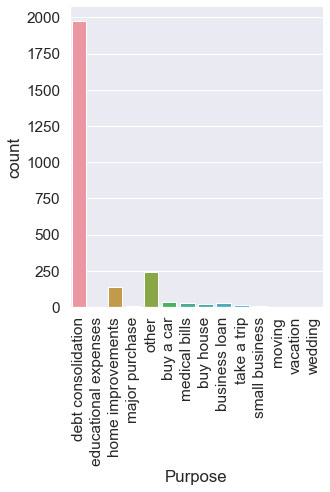

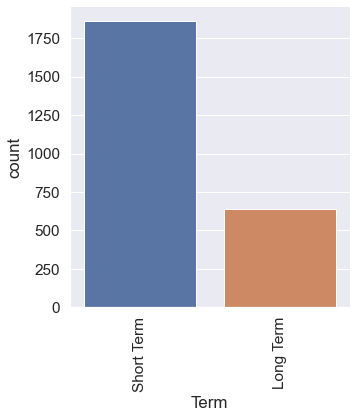

In [47]:
categorical_eda(test_df)

***Вывод:***

распределение категориальных переменных Home_Ownership, Years_in_current_job и Purpose различается в train'е и test'е

**Построение новых признаков**

In [48]:
for cat_colname in train_df.select_dtypes(include='object').columns[1:]:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)

In [49]:
train_df.rename(columns = {'Years_in_current_job_< 1 year':'Years_in_current_job_less_1_year',
                             'Years_in_current_job_1 year':'Years_in_current_job_1_year',
                             'Years_in_current_job_10+ years':'Years_in_current_job_10+_years',
                             'Years_in_current_job_2 years':'Years_in_current_job_2_years',
                             'Years_in_current_job_3 years':'Years_in_current_job_3_years',
                             'Years_in_current_job_4 years':'Years_in_current_job_4_years',
                             'Years_in_current_job_5 years':'Years_in_current_job_5_years',
                             'Years_in_current_job_6 years':'Years_in_current_job_6_years',
                             'Years_in_current_job_7 years':'Years_in_current_job_7_years',
                             'Years_in_current_job_8 years':'Years_in_current_job_8_years',
                             'Years_in_current_job_9 years':'Years_in_current_job_9_years',
                             'Purpose_business loan':'Purpose_business_loan',
                             'Purpose_buy a car':'Purpose_buy_a_car',
                             'Purpose_buy house':'Purpose_buy_house',
                             'Purpose_debt consolidation':'Purpose_debt_consolidation',
                             'Purpose_educational expenses':'Purpose_educational_expenses',
                             'Purpose_home improvements':'Purpose_home_improvements',
                             'Purpose_major purchase':'Purpose_major_purchase',
                             'Purpose_medical bills':'Purpose_medical_bills',
                             'Purpose_renewable energy':'Purpose_renewable_energy',
                             'Purpose_small business':'Purpose_small_business',
                             'Purpose_take a trip':'Purpose_take_a_trip',
                             'Term_Long Term':'Long_Term',
                             'Term_Short Term':'Short_Term',
                            }, inplace = True)

In [50]:
DUMMY_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [51]:
train_df['Credit_Score_bin'] = 0
train_df.loc[train_df['Credit_Score'] > 5500, 'Credit_Score_bin'] = 1

In [52]:
train_df['Annual_Income_out'] = 0
train_df.loc[train_df['Annual_Income'] > 1627711, 'Annual_Income_out'] = 1

In [53]:
train_df['Number_of_Open_Accounts_out'] = 0
train_df.loc[train_df['Number_of_Open_Accounts'] > 14, 'Number_of_Open_Accounts_out'] = 1

In [54]:
train_df['Years_of_Credit_History_out'] = 0
train_df.loc[train_df['Years_of_Credit_History'] > 22, 'Years_of_Credit_History_out'] = 1

In [55]:
train_df['Current_Credit_Balance_out'] = 0
train_df.loc[train_df['Current_Credit_Balance'] > 358815, 'Current_Credit_Balance_out'] = 1

In [56]:
train_df['Monthly_Debt_out'] = 0
train_df.loc[train_df['Monthly_Debt'] > 23720, 'Monthly_Debt_out'] = 1

In [57]:
train_df['Credit_Score_out'] = 0
train_df.loc[train_df['Credit_Score'] > 743, 'Credit_Score_out'] = 1

In [58]:
OUT_FEATURE_NAMES = ['Credit_Score_bin',
                      'Annual_Income_out',
                      'Number_of_Open_Accounts_out',
                      'Years_of_Credit_History_out',
                      'Current_Credit_Balance_out',
                      'Monthly_Debt_out',
                      'Credit_Score_out']

**Обработка пропусков**

<AxesSubplot:>

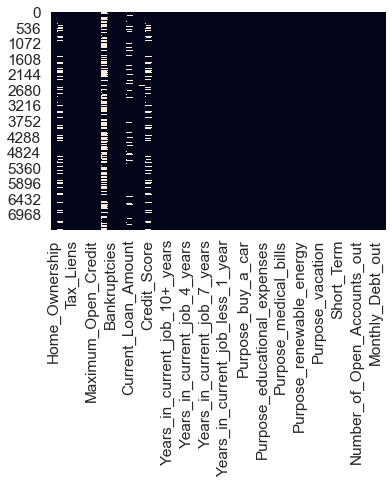

In [59]:
sns.heatmap(train_df.isnull(), cbar=False)

In [60]:
train_df.isna().sum()

Home_Ownership                         0
Annual_Income                       1601
Years_in_current_job                   0
Tax_Liens                              0
Number_of_Open_Accounts                6
Years_of_Credit_History                1
Maximum_Open_Credit                    3
Number_of_Credit_Problems              0
Months_since_last_delinquent        4082
Bankruptcies                          14
Purpose                                0
Term                                   0
Current_Loan_Amount                  870
Current_Credit_Balance                10
Monthly_Debt                          20
Credit_Score                        1557
Credit_Default                         0
Years_in_current_job_1_year            0
Years_in_current_job_10+_years         0
Years_in_current_job_2_years           0
Years_in_current_job_3_years           0
Years_in_current_job_4_years           0
Years_in_current_job_5_years           0
Years_in_current_job_6_years           0
Years_in_current

In [61]:
train_df['Annual_Income_nan'] = pd.isnull(train_df['Annual_Income'])
train_df['Number_of_Open_Accounts_nan'] = pd.isnull(train_df['Number_of_Open_Accounts'])
train_df['Years_of_Credit_History_nan'] = pd.isnull(train_df['Years_of_Credit_History'])
train_df['Maximum_Open_Credit_nan'] = pd.isnull(train_df['Maximum_Open_Credit'])
train_df['Months_since_last_delinquent_nan'] = pd.isnull(train_df['Months_since_last_delinquent'])
train_df['Current_Loan_Amount_nan'] = pd.isnull(train_df['Current_Loan_Amount'])
train_df['Current_Credit_Balance_nan'] = pd.isnull(train_df['Current_Credit_Balance'])
train_df['Monthly_Debt_nan'] = pd.isnull(train_df['Monthly_Debt'])
train_df['Credit_Score_nan'] = pd.isnull(train_df['Credit_Score'])
train_df['Bankruptcies_nan'] = pd.isnull(train_df['Bankruptcies'])

In [62]:
NAN_MARK_FEATURE_NAMES = ['Annual_Income_nan',
                          'Number_of_Open_Accounts_nan',
                          'Years_of_Credit_History_nan',
                          'Maximum_Open_Credit_nan',
                          'Months_since_last_delinquent_nan',
                          'Current_Loan_Amount_nan',
                          'Current_Credit_Balance_nan',
                          'Monthly_Debt_nan',
                          'Credit_Score_nan',
                          'Bankruptcies_nan']
NAN_FEATURE_NAMES = ['Annual_Income',
                     'Number_of_Open_Accounts',
                     'Years_of_Credit_History',
                     'Maximum_Open_Credit',
                     'Months_since_last_delinquent',
                     'Current_Loan_Amount',
                     'Current_Credit_Balance',
                     'Monthly_Debt',
                     'Credit_Score',
                     'Bankruptcies']

По хорошему надо сделать def, в котором проверять все колонки на наличие пропусков, если есть, записывать имя колонки и создавать для нее копию с обозначением пропусков.

In [63]:
def imputer_median(data):
    nan_features = []
    for col in data.columns:
        if data[col].isna().sum() > 0:
            nan_features.append(col)
            if data[col].dtypes != object:
                median = data[col].median()
                data[col].fillna(median, inplace=True)
            else:
                mode = data[col].mode()
                data[col].fillna(mode, inplace=True)
    return data

In [64]:
train_imp_median = imputer_median(train_df)

In [65]:
train_imp = train_imp_median.drop(CAT_FEATURE_NAMES, axis = 1)

In [66]:
train_imp.loc[train_imp['Annual_Income_nan'] == True, 'Annual_Income'] = np.nan

In [67]:
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Annual_Income')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8316402440064932
r2 на test: 0.717065990384745


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [68]:
train_imp.loc[train_imp['Number_of_Open_Accounts_nan'] == True, 'Number_of_Open_Accounts'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Number_of_Open_Accounts')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8200687329527828
r2 на test: 0.6787267287834922


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [69]:
train_imp.loc[train_imp['Years_of_Credit_History_nan'] == True, 'Years_of_Credit_History'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Years_of_Credit_History')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8013318840194295
r2 на test: 0.6792334879405748


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [70]:
train_imp.loc[train_imp['Maximum_Open_Credit_nan'] == True, 'Maximum_Open_Credit'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Maximum_Open_Credit')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8825322973337736
r2 на test: -0.26313694696697465


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [71]:
train_imp.loc[train_imp['Months_since_last_delinquent_nan'] == True, 'Months_since_last_delinquent'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Months_since_last_delinquent')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.4025133747468388
r2 на test: 0.012648257804086183


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [72]:
train_imp.loc[train_imp['Current_Loan_Amount_nan'] == True, 'Current_Loan_Amount'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Current_Loan_Amount')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7741049047260969
r2 на test: 0.5081506022835768


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [73]:
train_imp.loc[train_imp['Current_Credit_Balance_nan'] == True, 'Current_Credit_Balance'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Current_Credit_Balance')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9409290279322562
r2 на test: 0.8090974086614653


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [74]:
train_imp.loc[train_imp['Monthly_Debt_nan'] == True, 'Monthly_Debt'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Monthly_Debt')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8915915328831586
r2 на test: 0.7812503394749969


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [75]:
train_imp.loc[train_imp['Credit_Score_nan'] == True, 'Credit_Score'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Credit_Score')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9995679706768741
r2 на test: 0.9976447857871591


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [76]:
train_imp.loc[train_imp['Bankruptcies_nan'] == True, 'Bankruptcies'] = np.nan
Annual_Income_predictor, train_imp = imputer_rfr(train_imp, 'Bankruptcies')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9415322857464323
r2 на test: 0.8368771868886593


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


**Масштабирование данных**

In [77]:
scaler = StandardScaler()

df_norm = train_imp.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

**Сохранение модели для масштабирования**

In [78]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Разбиение на train и valid**

In [79]:
X = df_norm[NUM_FEATURE_NAMES + DUMMY_FEATURE_NAMES + OUT_FEATURE_NAMES]
y = df_norm[TARGET_NAME]

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

**Балансировка данных**

In [80]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='tomek')
    
df_balanced[TARGET_NAME].value_counts()

0    3437
1    1479
Name: Credit_Default, dtype: int64

In [81]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [82]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    3771
0    3771
Name: Credit_Default, dtype: int64

In [83]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Обучение модели<a class="anchor" id="train_test_saving"></a> 

**Логистическая регрессия**

In [84]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train_balanced, X_val, y_train_balanced, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      3771
           1       0.94      0.21      0.34      3771

    accuracy                           0.60      7542
   macro avg       0.75      0.60      0.53      7542
weighted avg       0.75      0.60      0.53      7542

TEST

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1616
           1       0.87      0.22      0.35       634

    accuracy                           0.77      2250
   macro avg       0.82      0.60      0.61      2250
weighted avg       0.79      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1596   20
1                495  139


**k ближайших соседей**

In [85]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train_balanced, X_val, y_train_balanced, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.95      0.77      3771
           1       0.90      0.48      0.63      3771

    accuracy                           0.71      7542
   macro avg       0.77      0.71      0.70      7542
weighted avg       0.77      0.71      0.70      7542

TEST

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1616
           1       0.47      0.22      0.30       634

    accuracy                           0.71      2250
   macro avg       0.61      0.56      0.56      2250
weighted avg       0.67      0.71      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1457  159
1                493  141


**Дерево решений**

In [86]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.5},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train_balanced, X_val, y_train_balanced, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.62      0.83      0.71      3771
           1       0.74      0.49      0.59      3771

    accuracy                           0.66      7542
   macro avg       0.68      0.66      0.65      7542
weighted avg       0.68      0.66      0.65      7542

TEST

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1616
           1       0.49      0.46      0.48       634

    accuracy                           0.71      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1316  300
1                343  291


**XGBoost**

In [87]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21, 
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train_balanced, X_val, y_train_balanced, y_val)

[22:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3771
           1       1.00      0.59      0.74      3771

    accuracy                           0.80      7542
   macro avg       0.85      0.80      0.79      7542
weighted avg       0.85      0.80      0.79      7542

TEST

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1616
           1       0.62      0.34      0.43       634

    accuracy                           0.75      2250
   macro avg       0.70      0.63      0.64      2250
weighted avg       0.73      0.75      0.73      2250

CONFUSION MATRIX

col_0

**LightGBM**

In [88]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:3.6},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train_balanced, X_val, y_train_balanced, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3771
           1       0.85      0.84      0.85      3771

    accuracy                           0.85      7542
   macro avg       0.85      0.85      0.85      7542
weighted avg       0.85      0.85      0.85      7542

TEST

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1616
           1       0.44      0.57      0.50       634

    accuracy                           0.68      2250
   macro avg       0.63      0.65      0.63      2250
weighted avg       0.71      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1160  456
1                270  364
Wall time: 236 ms


**CatBoost**

In [89]:
cat_df = pd.concat([train_imp, train_imp_median[CAT_FEATURE_NAMES]], axis = 1)

In [90]:
X = cat_df[BASE_FEATURE_NAMES + OUT_FEATURE_NAMES]
y = train_imp[TARGET_NAME]

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [92]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [93]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3771
           1       0.75      0.82      0.78      1479

    accuracy                           0.87      5250
   macro avg       0.84      0.86      0.84      5250
weighted avg       0.88      0.87      0.87      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1616
           1       0.49      0.51      0.50       634

    accuracy                           0.71      2250
   macro avg       0.64      0.65      0.65      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1276  340
1                313  321


In [94]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=50,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                     )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 3.09 s


In [95]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.6599053414469236,
  'Logloss': 0.5219015342360219,
  'F1': 0.7174059676365436,
  'Precision:use_weights=false': 0.5900846432889963,
  'Precision:use_weights=true': 0.7858836726187368,
  'Recall:use_weights=true': 0.6599053414469236},
 'validation': {'Recall:use_weights=false': 0.5378548895899053,
  'Logloss': 0.5866527183976641,
  'F1': 0.613159767244404,
  'Precision:use_weights=false': 0.5200729927007299,
  'Precision:use_weights=true': 0.7342530490030751,
  'Recall:use_weights=true': 0.5378548895899053}}

In [96]:
evaluate_preds(model_catb, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3771
           1       0.57      0.62      0.59      1479

    accuracy                           0.76      5250
   macro avg       0.70      0.72      0.71      5250
weighted avg       0.77      0.76      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1616
           1       0.49      0.54      0.51       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1266  350
1                293  341


**Выбор лучшей модели и подбор гиперпараметров**

In [97]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':50
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [98]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [99]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [100]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6656267441
bestIteration = 1

0:	loss: 0.6656267	best: 0.6656267 (0)	total: 555ms	remaining: 7.77s

bestTest = 0.6138072191
bestIteration = 193

1:	loss: 0.6138072	best: 0.6656267 (0)	total: 2.99s	remaining: 19.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6394670391
bestIteration = 340

2:	loss: 0.6394670	best: 0.6656267 (0)	total: 6.92s	remaining: 27.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6394670391
bestIteration = 340

3:	loss: 0.6394670	best: 0.6656267 (0)	total: 10.5s	remaining: 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6394670391
bestIteration = 340

4:	loss: 0.6394670	best: 0.6656267 (0)	total: 14.2s	remaining: 28.4s

bestTest = 0.6058315054
bestIteration = 0

5:	loss: 0.6058315	best: 0.6656267 (0)	total: 14.9s	remaining: 22.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6789387015
bestIteration = 4

6:	loss: 0.6789387	best: 0.6789387 (6)	total: 15.8s	rema

In [101]:
grid_search

{'params': {'depth': 5, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [102]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
6            6      0.621979     0.027939       0.646961      0.031985   
5            5      0.620990     0.025570       0.648114      0.033031   
4            4      0.620158     0.027965       0.646699      0.033155   
31          31      0.618178     0.031244       0.635414      0.013304   
7            7      0.617756     0.026033       0.644657      0.034201   

    test-Logloss-mean  test-Logloss-std  train-Logloss-mean  train-Logloss-std  
6            0.643257          0.002277            0.641366           0.001526  
5            0.648292          0.002244            0.646557           0.001459  
4            0.653942          0.001639            0.652533           0.001307  
31           0.600635          0.004566            0.592509           0.001802  
7            0.638586          0.002379            0.636520           0.001548

In [103]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=500, max_depth=3)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

evaluate_preds(final_model, X_train, X_val, y_train, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.52      0.64      3771
           1       0.38      0.76      0.51      1479

    accuracy                           0.59      5250
   macro avg       0.61      0.64      0.57      5250
weighted avg       0.72      0.59      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.52      0.64      1616
           1       0.37      0.73      0.49       634

    accuracy                           0.58      2250
   macro avg       0.60      0.62      0.57      2250
weighted avg       0.70      0.58      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               839  777
1               172  462
Wall time: 723 ms


**Вывод**

Лучшая модель Catboost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     ))
                                     
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3771
           1       0.57      0.62      0.59      1479

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1616
           1       0.49      0.54      0.51       634
